# 1) Setup & Install
Install dependencies for Gymnasium and Stable-Baselines3.


In [ ]:
# 1) Setup & Install — deps for RL and plotting
# First, uninstall conflicting packages that may be pre-installed in the Colab environment.
!pip uninstall -y dopamine-rl gym > /dev/null 2>&1

# Install stable, non-yanked versions of SB3 and Gymnasium known to be compatible.
!pip -q install gymnasium==0.28.1 stable-baselines3==2.2.1 tensorboard matplotlib pandas

# 2) Google Drive Mount
Access TimesNet embeddings stored in Drive.


In [ ]:
# 2) Google Drive Mount — access data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 3) Configuration
Paths, market specifics, costs, rewards, Guardian thresholds, and PPO hyperparameters.


In [ ]:
# 3) Configuration — paths and parameters
import os

# Data paths (TimesNet embeddings)
DATA_DIR = '/content/drive/MyDrive/timesnet_mnq/embeddings/'  # Corrected to be a directory
TRAIN_NPZ = os.path.join(DATA_DIR, 'train_emb_avg.npz')
VAL_NPZ   = os.path.join(DATA_DIR, 'val_emb_avg.npz')
TEST_NPZ  = os.path.join(DATA_DIR, 'test_emb_avg.npz')
META_JSON = os.path.join(DATA_DIR, 'embeddings_meta.json')

# OHLC paths for ATR only (no direct use in observations)
RAW_DATA_DIR = '/content'  # where you upload mnq_complete_dataset.csv in Colab
TRAIN_OHLC_CSV = os.path.join(RAW_DATA_DIR, 'mnq_train.csv')
VAL_OHLC_CSV   = os.path.join(RAW_DATA_DIR, 'mnq_val.csv')
TEST_OHLC_CSV  = os.path.join(RAW_DATA_DIR, 'mnq_test.csv')
OHLC_RESAMPLE_RULE = '5min'  # aggregate 1-min to 5-min to match TimesNet (pandas>=2 warning safe)

# Bar timing (5-minute bars) and annualization
BAR_SECONDS = 300
STEPS_PER_DAY = 288  # 24*60/5
STEPS_PER_YEAR = int(STEPS_PER_DAY * 252)

# Market specifics
POINT_VALUE_MNQ = 2.0      # USD per point
TICK_SIZE = 0.25
TICK_VALUE_USD = POINT_VALUE_MNQ * TICK_SIZE  # $0.50 per tick

# Costs and toggles
FIXED_COMMISSION_USD = 0.10  # round-trip all-in (entry+exit)
# Slippage fixo em ticks (round-trip modelado na entrada); baseline off
FIXED_SLIPPAGE_TICKS = 0
FIXED_SLIPPAGE_USD = FIXED_SLIPPAGE_TICKS * TICK_VALUE_USD
ATR_SLIPPAGE_MULTIPLIER = 0.25  # deprecated
# Experiment toggles (mude 1 por vez)
TRAIN_SLIPPAGE_ON = False
EVAL_SLIPPAGE_ON = False
GUARDIAN_TIGHT = False  # se True, usa SL/TS 1.5x e BE 1.0x

# Risk parameters (training env termination)
MAX_EPISODE_DRAWDOWN_USD = 500.0

# Reward policy coefficients (scaled to be impactful)
# For a $20 drawdown: penalty = 0.0002 * (20**2) = 0.08
# Profit bonus disabled initially to simplify learning
DRAWDOWN_PENALTY_COEFF = 0.0
PROFIT_KEEPING_BONUS_COEFF = 0.0
PATIENCE_BONUS = 0.0
CHOPPY_ATR_TO_PRICE_MAX = 0.0

# Guardian thresholds (backtest only, ATR-based)
GUARDIAN_SL_ATR_MULTIPLIER = 2.0
GUARDIAN_TS_ATR_MULTIPLIER = 2.0
GUARDIAN_BE_ACTIVATION_ATR_MULTIPLIER = 1.5
GUARDIAN_BE_PLUS_TICKS = 2  # +2 ticks beyond entry when BE activates

# Environment
EPISODE_LENGTH = 1024
N_ENVS = 8
SEED = 42

# PPO (SB3) hyperparameters — tuned for L4 22GB (cap 75% VRAM)
# Keep rollout size constant, increase batch to leverage GPU without exceeding memory cap.
PPO_KW = dict(
    learning_rate=3e-4,
    n_steps=2048,             # with N_ENVS=8 → rollout = 16384
    batch_size=1024,          # divisor of rollout; increases GPU utilization
    n_epochs=6,               # fewer epochs with larger batch
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.005,           # fixed (schedule disabled for stability)
    vf_coef=0.5,
    max_grad_norm=0.5,
    target_kl=0.03,           # early stop PPO updates if divergence too high
)

# Training run cadence
TOTAL_TIMESTEPS = 1_000_000
EVAL_FREQ_STEPS = 20480
LOG_DIR = '/content/drive/MyDrive/timesnet_mnq/ppo_logs'
BEST_MODEL_PATH = os.path.join(LOG_DIR, 'best_model.zip')
os.makedirs(LOG_DIR, exist_ok=True)

In [ ]:
import numpy as np
import os

# Assuming DATA_DIR is correctly set in a previous cell
# If not, you may need to define it here or run the configuration cell first.
try:
    with np.load(TRAIN_NPZ, allow_pickle=False) as Z:
        print(f"Keys in {TRAIN_NPZ}: {list(Z.keys())}")
except FileNotFoundError:
    print(f"Error: {TRAIN_NPZ} not found. Please ensure DATA_DIR is set correctly and the file exists.")

# 4) Imports & Utilities
Helpers for data loading and metrics (Calmar, Sharpe, MDD).


In [ ]:
# 4) Imports & Utilities — loaders and metrics
import json, math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from typing import Optional

def _read_ohlc_csv(csv_path: str, resample_rule: Optional[str] = None):
    import pandas as pd
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').set_index('timestamp')
    if resample_rule:
        # Match TimesNet resample semantics: right-closed, right-labeled bars
        agg_base = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
        agg = {col: agg_base.get(col, 'last') for col in df.columns}
        df = df.resample(resample_rule, label='right', closed='right').agg(agg)
        df = df.dropna(how='any').reset_index()
    return df

def _atr_wilder(high: np.ndarray, low: np.ndarray, close: np.ndarray, period: int = 14) -> np.ndarray:
    high = high.astype(np.float64)
    low = low.astype(np.float64)
    close = close.astype(np.float64)
    n = len(close)
    atr = np.empty(n, dtype=np.float64)
    prev_close = close[0]
    tr0 = max(high[0]-low[0], abs(high[0]-prev_close), abs(low[0]-prev_close))
    atr[0] = tr0
    for t in range(1, n):
        tr = max(high[t]-low[t], abs(high[t]-close[t-1]), abs(low[t]-close[t-1]))
        if t < period:
            atr[t] = (atr[t-1]*t + tr) / (t+1)
        else:
            atr[t] = (atr[t-1]*(period-1) + tr) / period
    return atr

def load_split(npz_path: str, ohlc_csv_path: Optional[str] = None, resample_rule: Optional[str] = None, atr_period: int = 14):
    with np.load(npz_path, allow_pickle=False) as Z:
        obs = Z['obs'] if 'obs' in Z.files else Z['X']
        start_idx = Z['start_idx']
        end_idx = Z['end_idx']
        close = Z['close'] if 'close' in Z.files else None
        atr = None
        for k in ['atr', 'ATR', 'atr_14', 'ATR_14']:
            if k in Z.files:
                atr = Z[k]
                break
    if close is None:
        raise ValueError('NPZ must contain close series')
    if ohlc_csv_path:
        df = _read_ohlc_csv(ohlc_csv_path, resample_rule)
        for col in ['high','low','close']:
            if col not in df.columns:
                raise ValueError(f'OHLC CSV must contain {col} column')
        atr_ohlc = _atr_wilder(df['high'].to_numpy(), df['low'].to_numpy(), df['close'].to_numpy(), period=atr_period)
        if len(atr_ohlc) != len(close):
            raise ValueError(f'Length mismatch between OHLC ({len(atr_ohlc)}) and NPZ close ({len(close)}). Provide split-matching OHLC CSV or adjust resample_rule.')
        atr = atr_ohlc
    if atr is None:
        raise ValueError("ATR not found. Provide ohlc_csv_path for ATR computation or include an 'atr' series in the NPZ.")
    return obs.astype(np.float32), start_idx.astype(np.int64), end_idx.astype(np.int64), close.astype(np.float64), atr.astype(np.float64)

def synth_time_features(n: int, steps_per_day: int = STEPS_PER_DAY) -> np.ndarray:
    t = np.arange(n, dtype=np.float32)
    hour_phase = 2*np.pi * (t % steps_per_day) / max(steps_per_day, 1)
    week_phase = 2*np.pi * (t % (steps_per_day*5)) / max(steps_per_day*5, 1)
    return np.stack([np.sin(hour_phase), np.cos(hour_phase), np.sin(week_phase), np.cos(week_phase)], axis=1).astype(np.float32)

def map_action_to_position(action: int) -> int:
    # 0->short(-1), 1->flat(0), 2->long(+1)
    return (-1 if action == 0 else (0 if action == 1 else 1))

def pnl_from_price_change(prev_pos: int, price_change: float, point_value: float) -> float:
    return float(prev_pos * price_change * point_value)

def compute_drawdown(equity: np.ndarray) -> np.ndarray:
    # Robust to negative equity: clamp ratio to [0,1] so DD ∈ [0,100%]
    peaks = np.maximum.accumulate(np.maximum(equity, 1e-9))
    ratio = np.divide(equity, peaks, out=np.zeros_like(peaks, dtype=np.float64), where=peaks>0)
    dd = 1.0 - np.clip(ratio, 0.0, 1.0)
    return dd

def max_drawdown(equity: np.ndarray) -> float:
    dd = compute_drawdown(equity)
    return float(np.nanmax(dd) if len(dd) else 0.0)

def cagr_from_equity(equity: np.ndarray) -> float:
    n = len(equity)
    if n < 2:
        return 0.0
    start = float(equity[0])
    years = n / max(STEPS_PER_YEAR, 1)
    if years <= 0 or start <= 0:
        return 0.0
    end = float(equity[-1])
    if end <= 0:
        return -1.0
    ratio = end / start
    return float(ratio ** (1.0 / years) - 1.0)

def calmar_ratio(equity: np.ndarray) -> float:
    mdd = max_drawdown(equity)
    cagr = cagr_from_equity(equity)
    if not np.isfinite(mdd) or not np.isfinite(cagr):
        return 0.0
    if mdd <= 1e-12:
        return float('inf') if cagr > 0 else 0.0
    return cagr / mdd

def sharpe_ratio(returns: np.ndarray, risk_free=0.0) -> float:
    if len(returns) < 2:
        return 0.0
    mean = float(np.mean(returns))
    std = float(np.std(returns, ddof=1))
    if std <= 1e-12:
        return 0.0
    ann_factor = math.sqrt(STEPS_PER_YEAR)
    return float((mean - risk_free) / std * ann_factor)

In [ ]:
# 3b) Materializar OHLC por split para ATR (alinha com os NPZ)
# Use quando você tiver um único CSV base (mnq_complete_dataset.csv) e quiser gerar train/val/test CSVs.
# Requer que os NPZ (TRAIN_NPZ/VAL_NPZ/TEST_NPZ) já existam no DATA_DIR.
import numpy as np, pandas as pd
BASE_OHLC_CSV = os.path.join(RAW_DATA_DIR, 'mnq_complete_dataset.csv')
if os.path.exists(BASE_OHLC_CSV):
    df_all = _read_ohlc_csv(BASE_OHLC_CSV, resample_rule=OHLC_RESAMPLE_RULE)
    def _len_close(npz_path):
        with np.load(npz_path, allow_pickle=False) as Z:
            return len(Z['close'] if 'close' in Z.files else Z['X'])
    n_train = _len_close(TRAIN_NPZ)
    n_val   = _len_close(VAL_NPZ)
    n_test  = _len_close(TEST_NPZ)
    total   = n_train + n_val + n_test
    if len(df_all) < total:
        raise ValueError(f'OHLC length {len(df_all)} < NPZ total {total}. Verifique CSV base e resample.')
    # Compensa warm-up/limpezas no TimesNet: corta excesso do início para casar os comprimentos
    excess = len(df_all) - total
    if excess > 0:
        df_all = df_all.iloc[excess:]
    assert len(df_all) == total
    os.makedirs(RAW_DATA_DIR, exist_ok=True)
    _train_csv = os.path.join(RAW_DATA_DIR, 'mnq_train.csv')
    _val_csv   = os.path.join(RAW_DATA_DIR, 'mnq_val.csv')
    _test_csv  = os.path.join(RAW_DATA_DIR, 'mnq_test.csv')
    df_all.iloc[:n_train].to_csv(_train_csv, index=False)
    df_all.iloc[n_train:n_train+n_val].to_csv(_val_csv, index=False)
    df_all.iloc[n_train+n_val:].to_csv(_test_csv, index=False)
    print('Wrote:', _train_csv, _val_csv, _test_csv)
    # Atualiza caminhos usados pelo PPO
    TRAIN_OHLC_CSV = _train_csv
    VAL_OHLC_CSV   = _val_csv
    TEST_OHLC_CSV  = _test_csv
else:
    print('BASE_OHLC_CSV não encontrado; pule esta célula se já tiver os CSVs por split.')


# 3c) GPU Tuning (L4 22GB)
Limit VRAM to 75% and enable fast matmul (TF32) when available.


In [ ]:
# 3c) GPU Tuning — cap VRAM and enable fast matmul
try:
    import torch
    if torch.cuda.is_available():
        try:
            torch.cuda.set_per_process_memory_fraction(0.75)
        except Exception as e:
            print('Warn: set_per_process_memory_fraction not supported:', e)
        try:
            torch.set_float32_matmul_precision('high')  # TF32 on Ampere+
        except Exception:
            pass
        torch.backends.cudnn.benchmark = True
        total = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        free, t = torch.cuda.mem_get_info()
        print(f'GPU: total={total:.1f} GB | free={(free/1024**3):.1f} GB (cap 75%)')
except Exception as e:
    print('GPU tuning cell skipped:', e)


# 5) Environment (MNQEmbEnv)
Training-only risk shaping on embeddings; no hard stops.


In [ ]:
# 5) Environment — MNQEmbEnv
class MNQEmbEnv(gym.Env):
    metadata = {'render.modes': []}
    def __init__(
        self,
        npz_path: str,
        meta_path: Optional[str] = None,
        ohlc_csv_path: Optional[str] = None,
        ohlc_resample_rule: Optional[str] = None,
        episode_length: int = EPISODE_LENGTH,
        point_value: float = POINT_VALUE_MNQ,
        fixed_commission_usd: float = FIXED_COMMISSION_USD,
        fixed_slippage_usd: float = FIXED_SLIPPAGE_USD,
        drawdown_penalty_coeff: float = DRAWDOWN_PENALTY_COEFF,
        profit_keeping_bonus_coeff: float = PROFIT_KEEPING_BONUS_COEFF,
        patience_bonus: float = PATIENCE_BONUS,
        choppy_atr_to_price_max: float = CHOPPY_ATR_TO_PRICE_MAX,
        max_episode_drawdown_usd: float = MAX_EPISODE_DRAWDOWN_USD,
        apply_slippage_costs: bool = False,
        seed: Optional[int] = None,
    ):
        super().__init__()
        self.rng = np.random.default_rng(seed)
        self.obs_raw, self.start_idx, self.end_idx, self.close, self.atr = load_split(npz_path, ohlc_csv_path=ohlc_csv_path, resample_rule=ohlc_resample_rule)
        self.meta = {}
        if meta_path and os.path.exists(meta_path):
            with open(meta_path, 'r') as f:
                self.meta = json.load(f)
        self.T, self.D = self.obs_raw.shape
        self.time_features = synth_time_features(self.T, STEPS_PER_DAY)
        self.point_value = float(point_value)
        self.fixed_commission = float(fixed_commission_usd)
        self.fixed_slippage = float(fixed_slippage_usd)
        self.apply_slippage_costs = bool(apply_slippage_costs)
        self.dd_penalty = float(drawdown_penalty_coeff)
        self.profit_bonus = float(profit_keeping_bonus_coeff)
        self.patience_bonus_v = float(patience_bonus)
        self.choppy_thr = float(choppy_atr_to_price_max)
        self.max_episode_dd = float(max_episode_drawdown_usd)
        self.episode_length = int(episode_length)

        # Observation: [embedding D] + [time 4] + [position 1] + [portfolio 3]
        self.obs_dim = self.D + 4 + 1 + 3
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
        self._reset_state()

    def _reset_state(self):
        min_start = 1
        max_start = max(min_start, self.T - self.episode_length - 2)
        self.start = int(self.rng.integers(min_start, max_start+1)) if max_start > min_start else min_start
        self.step_in_ep = 0
        self.current_step = self.start
        self.current_position = 0
        self.entry_price = 0.0
        self.best_price = 0.0
        self.entry_step = 0
        self.equity = 1000.0
        self.peak_equity = self.equity
        self.equity_series = [self.equity]
        self.returns_series = []

    def is_market_choppy(self, t: int) -> bool:
        price = float(self.close[t])
        if price <= 0:
            return False
        return (float(self.atr[t]) / price) <= self.choppy_thr

    def _get_obs(self) -> np.ndarray:
        emb = self.obs_raw[self.current_step].astype(np.float32)
        tf = self.time_features[self.current_step].astype(np.float32)
        pf = np.array([self.current_position], dtype=np.float32)
        # === Portfolio features ===
        if self.current_position != 0:
            atr_entry = float(max(self.atr[self.entry_step], 1e-9))
            pnl_usd = (float(self.close[self.current_step]) - self.entry_price) * self.current_position * self.point_value
            pnl_norm = float(pnl_usd) / max(atr_entry * self.point_value, 1e-9)
            bars_in_trade = max(0, self.current_step - int(self.entry_step))
        else:
            pnl_norm = 0.0
            bars_in_trade = 0
        dur_norm = float(bars_in_trade) / max(self.episode_length, 1)
        dd_usd = float(self.peak_equity - self.equity)
        dd_norm = dd_usd / max(self.max_episode_dd, 1e-6)
        portfolio_state = np.array([pnl_norm, dur_norm, dd_norm], dtype=np.float32)
        return np.concatenate([emb, tf, pf, portfolio_state], axis=0)

    def reset(self, *, seed: Optional[int] = None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self._reset_state()
        return self._get_obs(), {}

    def step(self, action: int):
        new_pos = map_action_to_position(int(action))
        prev_pos = self.current_position
        t = self.current_step
        prev_t = max(0, t-1)

        # Price change and gross PnL for the previous position
        price_change = float(self.close[t] - self.close[prev_t])
        gross_pnl = pnl_from_price_change(prev_pos, price_change, self.point_value)

        # Transaction costs: charge full round-trip cost only on new trade entry (from flat or reversal)
        costs = 0.0
        is_new_trade_entry = ((prev_pos == 0 and new_pos != 0) or
                              (np.sign(new_pos) != np.sign(prev_pos) and new_pos != 0))
        # Report slippage, but do not apply to equity unless enabled
        entry_intended_price = None
        entry_fill_price_reported = None
        entry_slippage_ticks = 0
        entry_slippage_usd = 0.0
        if is_new_trade_entry:
            commission = self.fixed_commission
            # Reported slippage: assume adverse 2 ticks from intended price
            entry_intended_price = float(self.close[t])
            entry_slippage_ticks = int(FIXED_SLIPPAGE_TICKS)
            entry_slippage_usd = float(self.fixed_slippage)
            entry_fill_price_reported = entry_intended_price + (entry_slippage_ticks * TICK_SIZE)
            slippage_cost = (self.fixed_slippage if self.apply_slippage_costs else 0.0)
            costs = commission + slippage_cost
        base_reward = gross_pnl - costs

        # Unrealized PnL of the active trade (based on prev_pos and prior entry)
        if prev_pos != 0:
            unrealized_pnl_prev = (float(self.close[t]) - self.entry_price) * prev_pos * self.point_value
        else:
            unrealized_pnl_prev = 0.0

        # Risk penalties and behavioral incentives
        current_trade_drawdown = max(0.0, -unrealized_pnl_prev)
        drawdown_penalty = self.dd_penalty * (current_trade_drawdown ** 2)
        current_trade_profit = max(0.0, unrealized_pnl_prev)
        profit_keeping_bonus = self.profit_bonus * current_trade_profit
        patience_bonus = (self.patience_bonus_v if self.is_market_choppy(t) and new_pos == 0 else
                          (-self.patience_bonus_v if self.is_market_choppy(t) and new_pos != 0 else 0.0))
        final_reward = base_reward - drawdown_penalty + profit_keeping_bonus + patience_bonus

        # Update equity statistics
        self.equity += gross_pnl - costs
        self.returns_series.append((gross_pnl - costs) / max(abs(self.equity_series[-1]), 1e-9))
        self.equity_series.append(self.equity)
        self.peak_equity = max(self.peak_equity, self.equity)
        episode_drawdown = self.peak_equity - self.equity
        terminated = episode_drawdown > self.max_episode_dd

        # Trade state management: handle new entries, exits, and reversals
        position_flipped = (np.sign(new_pos) != np.sign(prev_pos))
        if (prev_pos == 0 and new_pos != 0) or (position_flipped and new_pos != 0):
            # New trade started (from flat or by reversal)
            self.entry_price = float(self.close[t])
            self.best_price = self.entry_price
            self.entry_step = int(t)
        elif new_pos == 0 and prev_pos != 0:
            # Trade closed
            self.entry_price = 0.0
            self.best_price = 0.0
            self.entry_step = int(self.current_step)
        elif new_pos == prev_pos and new_pos != 0:
            # Position maintained: update best price favorably
            if new_pos > 0:
                self.best_price = max(self.best_price, float(self.close[t]))
            else:
                self.best_price = min(self.best_price, float(self.close[t]))

        # Advance step
        self.current_position = new_pos
        self.current_step += 1
        self.step_in_ep += 1
        truncated = (self.step_in_ep >= self.episode_length) or (self.current_step >= (self.T - 1))
        obs = self._get_obs()
        info = {
            'gross_pnl': gross_pnl,
            'costs': costs,
            'equity': self.equity,
            'drawdown': episode_drawdown,
            'position': self.current_position,
            'entry_intended_price': entry_intended_price,
            'entry_fill_price_reported': entry_fill_price_reported,
            'entry_slippage_ticks': entry_slippage_ticks,
            'entry_slippage_usd': entry_slippage_usd,
        }
        return obs, float(final_reward), bool(terminated), bool(truncated), info



# 6) Guardian & Backtester
Guardian applies SL/TS/BE in inference; backtester runs full pass.


In [12]:
# 6) Guardian & Backtester — inference safety layer
class Guardian:
    def __init__(self, point_value=POINT_VALUE_MNQ,
                 sl_atr_mult=GUARDIAN_SL_ATR_MULTIPLIER,
                 ts_atr_mult=GUARDIAN_TS_ATR_MULTIPLIER,
                 be_activation_atr_mult=GUARDIAN_BE_ACTIVATION_ATR_MULTIPLIER,
                 be_plus_ticks=GUARDIAN_BE_PLUS_TICKS):
        self.point_value = float(point_value)
        self.sl_mult = float(sl_atr_mult)
        self.ts_mult = float(ts_atr_mult)
        self.be_act_mult = float(be_activation_atr_mult)
        self.be_plus_ticks = int(be_plus_ticks)

def run_backtest(model, env_like: MNQEmbEnv, guardian: Guardian, deterministic=True, collect_reports=False):
    obs_raw = env_like.obs_raw
    close = env_like.close
    atr = env_like.atr
    T = min(len(obs_raw), len(close), len(atr))
    close = close[:T]
    atr = atr[:T]
    position = 0
    entry_price = 0.0
    entry_step = None
    best_price = 0.0
    be_activated = False
    stop_level = None
    equity = 1000.0
    peak_equity = equity
    equity_series = [equity]
    step_returns = []
    tf_all = synth_time_features(T, STEPS_PER_DAY)
    trade_reports = [] if collect_reports else None
    for t in range(1, T):
        # 1) Guardian updates and veto (if position open)
        if position != 0:
            # Initial hard stop if just opened
            if stop_level is None:
                if position > 0:
                    stop_level = entry_price - guardian.sl_mult * float(atr[t])
                else:
                    stop_level = entry_price + guardian.sl_mult * float(atr[t])
            # Break-even activation
            be_trigger = guardian.be_act_mult * float(atr[t])
            be_offset = guardian.be_plus_ticks * TICK_SIZE
            if not be_activated:
                if position > 0 and (float(close[t]) - entry_price) >= be_trigger:
                    stop_level = max(stop_level, entry_price + be_offset)
                    be_activated = True
                elif position < 0 and (entry_price - float(close[t])) >= be_trigger:
                    stop_level = min(stop_level, entry_price - be_offset)
                    be_activated = True
            # Trailing stop
            if position > 0:
                trail = best_price - guardian.ts_mult * float(atr[t])
                stop_level = max(stop_level, trail)
            else:
                trail = best_price + guardian.ts_mult * float(atr[t])
                stop_level = min(stop_level, trail)
            # Veto: close if price crosses stop
            if (position > 0 and float(close[t]) <= stop_level) or (position < 0 and float(close[t]) >= stop_level):
                # Apply PnL for this step (no extra costs; paid on entry)
                price_change = float(close[t] - close[t-1])
                gross_pnl = pnl_from_price_change(position, price_change, env_like.point_value)
                equity += gross_pnl
                peak_equity = max(peak_equity, equity)
                equity_series.append(equity)
                step_returns.append(gross_pnl / max(abs(equity_series[-2]), 1e-9))
                # Close position and reset trade state
                position = 0
                entry_price = 0.0
                entry_step = None
                best_price = 0.0
                be_activated = False
                stop_level = None
                continue

        # 2) PPO acts if Guardian did not veto

        # === CONSTRUÇÃO DE ESTADO IDÊNTICA AO AMBIENTE DE TREINO ===
        if position != 0:
            atr_entry_idx = entry_step if entry_step is not None else t
            atr_entry = float(max(atr[atr_entry_idx], 1e-9))
            pnl_usd = (float(close[t]) - entry_price) * position * env_like.point_value
            pnl_norm = pnl_usd / max(atr_entry * env_like.point_value, 1e-9)
            bars_in_trade = max(0, t - atr_entry_idx)
        else:
            pnl_norm = 0.0
            bars_in_trade = 0

        dur_norm = float(bars_in_trade) / max(EPISODE_LENGTH, 1)
        dd_usd = float(max(peak_equity - equity, 0.0))
        dd_norm = dd_usd / max(MAX_EPISODE_DRAWDOWN_USD, 1e-6)

        portfolio_state = np.array([pnl_norm, dur_norm, dd_norm], dtype=np.float32)
        state = np.concatenate([
            obs_raw[t].astype(np.float32),
            tf_all[t].astype(np.float32),
            np.array([position], dtype=np.float32),
            portfolio_state
        ])
        # ==========================================================

        action, _ = model.predict(state, deterministic=deterministic)
        desired_pos = map_action_to_position(int(action))

        # 3) Execute decision (apply PnL for previous position)
        prev_pos = position
        price_change = float(close[t] - close[t-1])
        gross_pnl = pnl_from_price_change(prev_pos, price_change, env_like.point_value)
        costs = 0.0
        is_new_trade_entry = ((prev_pos == 0 and desired_pos != 0) or (np.sign(desired_pos) != np.sign(prev_pos) and desired_pos != 0))
        # Report slippage, but do not apply to equity unless enabled
        if is_new_trade_entry:
            commission = env_like.fixed_commission
            slippage_cost = (env_like.fixed_slippage if getattr(env_like, 'apply_slippage_costs', False) else 0.0)
            costs = commission + slippage_cost
            # Build trade report (entry)
            if collect_reports:
                intended_price = float(close[t])
                slip_ticks = int(FIXED_SLIPPAGE_TICKS)
                fill_price_reported = intended_price + (slip_ticks * TICK_SIZE)
                trade_reports.append(dict(
                    t=int(t),
                    side=int(np.sign(desired_pos)),
                    entry_intended_price=intended_price,
                    entry_fill_price_reported=fill_price_reported,
                    entry_slippage_ticks=slip_ticks,
                    entry_slippage_usd=float(env_like.fixed_slippage),
                    commission_usd=float(commission),
                    costs_charged_usd=float(costs),
                ))
        equity += gross_pnl - costs
        peak_equity = max(peak_equity, equity)
        equity_series.append(equity)
        step_returns.append((gross_pnl - costs) / max(abs(equity_series[-2]), 1e-9))

        # 4) Update trade state (entries, exits, reversals)
        if (prev_pos == 0 and desired_pos != 0) or (np.sign(desired_pos) != np.sign(prev_pos) and desired_pos != 0):
            entry_price = float(close[t])
            entry_step = int(t)
            best_price = entry_price
            be_activated = False
            stop_level = None
        elif desired_pos == 0 and prev_pos != 0:
            entry_price = 0.0
            entry_step = None
            best_price = 0.0
            be_activated = False
            stop_level = None
        elif desired_pos == prev_pos and desired_pos != 0:
            if desired_pos > 0:
                best_price = max(best_price, float(close[t]))
            else:
                best_price = min(best_price, float(close[t]))
        position = desired_pos

    # Always return a 3-tuple for type stability; trade_reports may be None
    return np.asarray(equity_series, dtype=np.float64), np.asarray(step_returns, dtype=np.float64), trade_reports



# 7) Calmar Callback
Early stopping by Calmar on validation backtests.


In [14]:
# 7) Calmar Callback — validation selection
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure

class CalmarCallback(BaseCallback):
    def __init__(self, eval_env_ctor, eval_env_kwargs, eval_freq, best_model_save_path, guardian_kwargs=None, verbose=1, early_stop_patience=None, early_stop_min_delta=0.0, early_stop_target=None):
        super().__init__(verbose)
        self.eval_env_ctor = eval_env_ctor
        self.eval_env_kwargs = eval_env_kwargs or {}
        self.eval_freq = int(eval_freq)
        self.best_model_save_path = best_model_save_path
        self.guardian_kwargs = guardian_kwargs or {}
        self.best_calmar = -np.inf
        # Early stopping config
        self.early_patience = (int(early_stop_patience) if early_stop_patience is not None else None)
        self.early_min_delta = float(early_stop_min_delta)
        self.early_target = (float(early_stop_target) if early_stop_target is not None else None)
        self._no_improve_evals = 0
        # live logging defaults
        self.log_tb = True
        self.plot_figures = True
        self.save_csv = False
        try:
            import os as _os
            self.log_dir = _os.path.dirname(best_model_save_path)
        except Exception:
            self.log_dir = None

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq != 0:
            return True
        eval_env = self.eval_env_ctor(**self.eval_env_kwargs)
        guardian = Guardian(**self.guardian_kwargs)
        # Collect trade_reports to log number of trades during validation
        equity, step_returns, trade_reports = run_backtest(self.model, eval_env, guardian, deterministic=True, collect_reports=True)
        calmar = calmar_ratio(equity)
        sharpe = sharpe_ratio(step_returns)
        mdd_v = max_drawdown(equity)
        cagr_v = cagr_from_equity(equity)
        trades_count = len(trade_reports) if trade_reports is not None else 0
        if self.verbose:
            print(f'[CalmarCallback] step={self.n_calls} calmar={calmar:.4f} best={self.best_calmar:.4f} | sharpe={sharpe:.3f} mdd={mdd_v:.2%} cagr={cagr_v:.2%} | trades={trades_count}')
        # TensorBoard scalars + figures
        if self.log_tb:
            self.logger.record('eval/calmar', float(calmar))
            self.logger.record('eval/sharpe', float(sharpe))
            self.logger.record('eval/mdd', float(mdd_v))
            self.logger.record('eval/cagr', float(cagr_v))
            self.logger.record('eval/trades', int(trades_count))
            if self.plot_figures:
                fig1 = plt.figure(figsize=(8, 2.4))
                plt.plot(equity)
                plt.title('Equity (val)')
                plt.grid(True)
                self.logger.record('eval/equity_curve', Figure(fig1, close=True), exclude=('stdout',))
                dd = compute_drawdown(equity)
                fig2 = plt.figure(figsize=(8, 2.0))
                plt.plot(dd)
                plt.title('Drawdown (val)')
                plt.grid(True)
                self.logger.record('eval/drawdown_curve', Figure(fig2, close=True), exclude=('stdout',))
        # Optional CSV snapshot
        if self.save_csv and self.log_dir is not None:
            try:
                import os, numpy as _np
                os.makedirs(self.log_dir, exist_ok=True)
                _np.savetxt(os.path.join(self.log_dir, f'equity_step_{self.n_calls}.csv'), equity, delimiter=',')
            except Exception as e:
                if self.verbose:
                    print('[CalmarCallback] CSV save failed:', e)
        improved = (calmar > (self.best_calmar + self.early_min_delta))
        if improved:
            self.best_calmar = calmar
            self._no_improve_evals = 0
            self.model.save(self.best_model_save_path)
        else:
            self._no_improve_evals += 1
        # Early target stop
        if (self.early_target is not None) and (calmar >= self.early_target):
            if self.verbose:
                print(f'[CalmarCallback] Early stop: target calmar {self.early_target:.4f} reached at step={self.n_calls}.')
            return False
        # Early patience stop
        if (self.early_patience is not None) and (self._no_improve_evals >= self.early_patience):
            if self.verbose:
                print(f'[CalmarCallback] Early stop: no improvement in {self.early_patience} evals (best={self.best_calmar:.4f}).')
            return False
        return True


# 7b) Entropy Schedule Callback
Anneal PPO entropy coefficient from a higher initial value to a lower final value.


In [ ]:
# 7b) Entropy Schedule Callback — linear decay of ent_coef
from stable_baselines3.common.callbacks import BaseCallback

class EntropyScheduleCallback(BaseCallback):
    def __init__(self, start: float, end: float, total_timesteps: int, verbose: int = 0):
        super().__init__(verbose)
        self.start = float(start)
        self.end = float(end)
        self.total_timesteps = int(total_timesteps)

    def _on_step(self) -> bool:
        # num_timesteps = total env steps seen by the model
        progress = min(1.0, self.num_timesteps / max(self.total_timesteps, 1))
        current = self.start + (self.end - self.start) * progress
        try:
            # PPO reads self.ent_coef during train(); updating here anneals it over time
            self.model.ent_coef = float(current)
        except Exception:
            pass
        try:
            self.logger.record('train/ent_coef', float(current))
        except Exception:
            pass
        return True


# 8) Training — SB3 PPO
Vectorized envs, CalmarCallback, and learn() loop.


In [ ]:
# 8) Training — SB3 PPO
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

def make_train_env():
    return MNQEmbEnv(
        npz_path=TRAIN_NPZ, meta_path=META_JSON, ohlc_csv_path=TRAIN_OHLC_CSV, ohlc_resample_rule=OHLC_RESAMPLE_RULE, episode_length=EPISODE_LENGTH,
        point_value=POINT_VALUE_MNQ, fixed_commission_usd=FIXED_COMMISSION_USD,
        fixed_slippage_usd=FIXED_SLIPPAGE_USD, apply_slippage_costs=TRAIN_SLIPPAGE_ON,
        drawdown_penalty_coeff=DRAWDOWN_PENALTY_COEFF,
        profit_keeping_bonus_coeff=PROFIT_KEEPING_BONUS_COEFF,
        patience_bonus=PATIENCE_BONUS, choppy_atr_to_price_max=CHOPPY_ATR_TO_PRICE_MAX,
        max_episode_drawdown_usd=MAX_EPISODE_DRAWDOWN_USD, seed=SEED
    )

def make_val_env():
    return MNQEmbEnv(
        npz_path=VAL_NPZ, meta_path=META_JSON, ohlc_csv_path=VAL_OHLC_CSV, ohlc_resample_rule=OHLC_RESAMPLE_RULE, episode_length=EPISODE_LENGTH,
        point_value=POINT_VALUE_MNQ, fixed_commission_usd=FIXED_COMMISSION_USD,
        fixed_slippage_usd=FIXED_SLIPPAGE_USD, apply_slippage_costs=False,
        drawdown_penalty_coeff=DRAWDOWN_PENALTY_COEFF,
        profit_keeping_bonus_coeff=PROFIT_KEEPING_BONUS_COEFF,
        patience_bonus=PATIENCE_BONUS, choppy_atr_to_price_max=CHOPPY_ATR_TO_PRICE_MAX,
        max_episode_drawdown_usd=MAX_EPISODE_DRAWDOWN_USD, seed=SEED+1
    )

vec_env = VecMonitor(DummyVecEnv([make_train_env for _ in range(N_ENVS)]), filename=None)
# Use a stable, lighter policy to avoid degenerate early behavior
from torch import nn
policy_kwargs = dict(net_arch=[1024, 512], activation_fn=nn.SiLU)

model = PPO('MlpPolicy', vec_env, policy_kwargs=policy_kwargs, tensorboard_log=LOG_DIR, seed=SEED, **PPO_KW)

# Guardian preset switcher via toggle
_sl_mult = 1.5 if GUARDIAN_TIGHT else GUARDIAN_SL_ATR_MULTIPLIER
_ts_mult = 1.5 if GUARDIAN_TIGHT else GUARDIAN_TS_ATR_MULTIPLIER
_be_act = 1.0 if GUARDIAN_TIGHT else GUARDIAN_BE_ACTIVATION_ATR_MULTIPLIER

calmar_cb = CalmarCallback(
    eval_env_ctor=MNQEmbEnv,
    eval_env_kwargs=dict(
        npz_path=VAL_NPZ, meta_path=META_JSON, ohlc_csv_path=VAL_OHLC_CSV, ohlc_resample_rule=OHLC_RESAMPLE_RULE, episode_length=EPISODE_LENGTH,
        point_value=POINT_VALUE_MNQ, fixed_commission_usd=FIXED_COMMISSION_USD,
        fixed_slippage_usd=FIXED_SLIPPAGE_USD, apply_slippage_costs=EVAL_SLIPPAGE_ON,
        drawdown_penalty_coeff=DRAWDOWN_PENALTY_COEFF,
        profit_keeping_bonus_coeff=PROFIT_KEEPING_BONUS_COEFF,
        patience_bonus=PATIENCE_BONUS, choppy_atr_to_price_max=CHOPPY_ATR_TO_PRICE_MAX,
        max_episode_drawdown_usd=MAX_EPISODE_DRAWDOWN_USD, seed=SEED+123
    ),
    eval_freq=EVAL_FREQ_STEPS,
    best_model_save_path=BEST_MODEL_PATH,
    guardian_kwargs=dict(point_value=POINT_VALUE_MNQ, sl_atr_mult=_sl_mult, ts_atr_mult=_ts_mult, be_activation_atr_mult=_be_act, be_plus_ticks=GUARDIAN_BE_PLUS_TICKS),
    verbose=1,
    early_stop_patience=5,          # stop if no Calmar improvement for 5 evals
    early_stop_min_delta=0.0,       # require strictly better Calmar
    early_stop_target=None          # or set a target Calmar to stop early
)

# Train with Calmar validation only (entropy schedule disabled for stability)
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=calmar_cb, progress_bar=True)


# 9) Final Backtest & Plots
Evaluate best model on the test split with Guardian and visualize results.


Test Calmar: 0.000 | Sharpe: 0.000 | MDD: 0.00% | CAGR: 0.00%


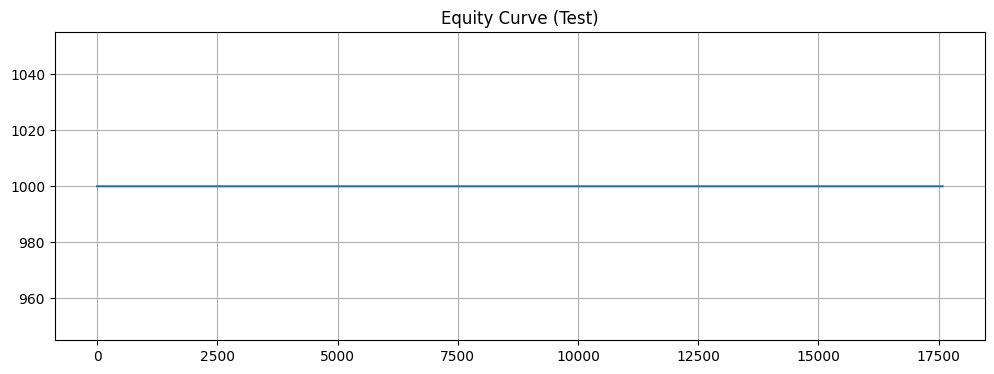

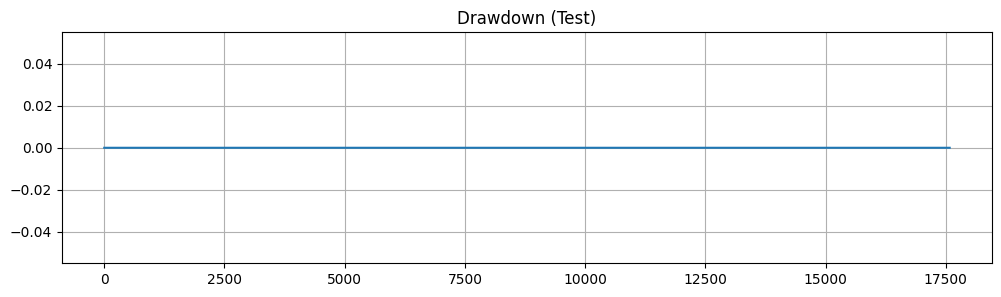

In [15]:
# 9) Final Backtest & Plots — test split evaluation
from stable_baselines3 import PPO
best_model = PPO.load(BEST_MODEL_PATH, device='auto')
test_env = MNQEmbEnv(
    npz_path=TEST_NPZ, meta_path=META_JSON, ohlc_csv_path=TEST_OHLC_CSV, ohlc_resample_rule=OHLC_RESAMPLE_RULE, episode_length=10**9,
    point_value=POINT_VALUE_MNQ, fixed_commission_usd=FIXED_COMMISSION_USD,
    fixed_slippage_usd=FIXED_SLIPPAGE_USD, apply_slippage_costs=EVAL_SLIPPAGE_ON,
    drawdown_penalty_coeff=DRAWDOWN_PENALTY_COEFF,
    profit_keeping_bonus_coeff=PROFIT_KEEPING_BONUS_COEFF,
    patience_bonus=PATIENCE_BONUS, choppy_atr_to_price_max=CHOPPY_ATR_TO_PRICE_MAX,
    max_episode_drawdown_usd=1e12, seed=SEED+999
)
# Guardian preset switcher for test as well
_sl_mult = 1.5 if GUARDIAN_TIGHT else GUARDIAN_SL_ATR_MULTIPLIER
_ts_mult = 1.5 if GUARDIAN_TIGHT else GUARDIAN_TS_ATR_MULTIPLIER
_be_act = 1.0 if GUARDIAN_TIGHT else GUARDIAN_BE_ACTIVATION_ATR_MULTIPLIER
# Guardian using same preset/toggle as training
guardian = Guardian(point_value=POINT_VALUE_MNQ,
                     sl_atr_mult=_sl_mult,
                     ts_atr_mult=_ts_mult,
                     be_activation_atr_mult=_be_act,
                     be_plus_ticks=GUARDIAN_BE_PLUS_TICKS)
equity, step_returns, trade_reports = run_backtest(best_model, test_env, guardian, deterministic=True, collect_reports=True)
# Log trade count and breakdown
num_trades = len(trade_reports) if trade_reports is not None else 0
num_longs = sum(1 for r in (trade_reports or []) if r.get('side', 0) > 0)
num_shorts = sum(1 for r in (trade_reports or []) if r.get('side', 0) < 0)
print(f'Trades: {num_trades} (long: {num_longs}, short: {num_shorts})')

calmar = calmar_ratio(equity)
sharpe = sharpe_ratio(step_returns)
mdd = max_drawdown(equity)
cagr = cagr_from_equity(equity)
print(f'Test Calmar: {calmar:.3f} | Sharpe: {sharpe:.3f} | MDD: {mdd:.2%} | CAGR: {cagr:.2%}')

plt.figure(figsize=(12,4))
plt.plot(equity)
plt.title('Equity Curve (Test)')
plt.grid(True)
plt.show()

dd = compute_drawdown(equity)
plt.figure(figsize=(12,3))
plt.plot(dd)
plt.title('Drawdown (Test)')
plt.grid(True)
plt.show()


# 10) TensorBoard Viewer
Visualize training and evaluation logs recorded by SB3.


In [ ]:
# 10) TensorBoard Viewer — launch inside notebook
%load_ext tensorboard
print(f"Using LOG_DIR={LOG_DIR}")
%tensorboard --logdir "$LOG_DIR" --port 6006
